# Datasets

In this notebook we describe and demonstrate the process of data acquisition, synthetic spectra generation and dataset composition. Training of our model requires three datasets - experimentally measured commercial NIST GS-EI-MS library (we use NIST20) and two much bigger synthetic datasets generated by open source models NEIMS and RASSP. The NIST dataset can be purchased from distributors listed [here](https://chemdata.nist.gov/dokuwiki/doku.php?id=chemdata:distributors), the synthetic datasets can be either generated with this notebook or downloaded from us (see **Precomputed datasets** below).

The only information about each molecule we need for training our model is:
    
```text
- SMILES:              "CCCCCCCCC(CCCC)O[Si]1(C)CCCCC1"
- list of m/z values:  [26, 27, 28, 31, ..., 200, 201, 255, 256, 257]
- list of intensities: [21.98, 335.7, 49.95, 737.34, ..., 23.98, 5.99, 78.93, 20.98, 5.0]
```

### 1) NIST dataset
This notebook first creates training, test and validation splits for NIST and converts them into `.jsonl` files. Each line of these files is a `json` with SMILES, m/z and intensities as keys representing a single molecule.

### 2) SMILES acquisition from ZINC
Secondly we download a subset of ZINC library (query *2d-standard-annotated-druglike*) that contains SMILES strings but no m/z nor intensities. We further filter the SMILES randomly to 30M, which creates a base for synthetic generation. 

### 3) RASSP synthetic spectra generation
Thirdly, we generate synthetic spectra using RASSP model. This model's molecular restrictions reduce the number of generated spectra to ???4.8M???. These spectra are split into training, validation and test sets.

### 4) NEIMS synthetic spectra generation
In the fourth step we use NEIMS model to generate synthetic spectra from the ???4.8M??? molecules permitted by RASSP (NEIMS does not have as strict molecular restrictions). These spectra are divided into **the same** training, validation and test splits as RASSP.

### 5) Dataleaks elimination
Finally we ensure there are no data leaks between NIST valid + test set (which will serve as the primary evaluation sets) and all the training data (RASSP train set, NEIMS train set and synthetic train sets). 

### Precomputed datasets
Synthetic spectra generation in full scale is very computationally intensive and requires a lot of resources. Therefore, we provide the prepared synthetic dataset in the form of a zip file that can be downloaded from the following link: ....

If the user chooses to use the precomputed datasets for training, he can perform step 1 with his o, skip the steps 2-4 and proceed directly to the dataleaks elimination step 5. 
If the user chooses to generate the synthetic datasets himself, he can go through all the steps and choose to process the whole dataset instead of just the toy example presented.

---------------------------------------------------------------------------

## 1) NIST dataset

### 1.1) NIST cleaning and splitting
The core part of this section is altered from a [notebook](https://github.com/Jozefov/mass-spectra-prediction-GCN/blob/master/Notebooks/data_preprocessing.ipynb) created by Filip Jozefov.

- in this subbsection we inspect the missing identifiers in NISt dataset
- we dorp ~60k of NIST spectra that don't have any form of a proper identifier (smiles, inchikey)
- we canonize the smiles strings and remove stereochemistry information
- we split the remaining data in the 0.8:0.1:0.1 ratio

In [90]:
from matchms.importing import load_from_msp
from matchms.exporting import save_as_msp
from matchms import Spectrum
import matchms

import pandas as pd
from rdkit import Chem

import numpy as np
import os
import random
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt

tqdm.pandas()

In [127]:
PROJECT_ROOT = '/home/xhajek9/gc-ms_bart/clean_paper' # TODO: change this to the path of your project root
NIST_PATH = '../data/datasets/NIST/NIST20/20210925_NIST_EI_MS_cleaned.msp' # TODO: change this to the path of your NIST20 dataset

In [6]:
nist_dataset = list(load_from_msp(NIST_PATH, metadata_harmonization=False))

In [7]:
np.random.seed(42)
random.seed(42)

#### Inspection of missing identifiers

In [9]:
# count examined occurrences of specific data missing in our dataset
def count_all(dataset):
    
    all_data = 0

    no_smiles = 0
    no_inchikey = 0
    no_inchi = 0

    no_smile_only = 0
    no_inchikey_only = 0
    both_missing_counter = 0

    all_identifier_missing = 0

    for obj in dataset:
        if obj.get('smiles') == None:
            no_smiles += 1
        if obj.get('inchikey') == None:
            no_inchikey += 1
        if obj.get('inchi') == None:
            no_inchi += 1
        if obj.get('smiles') == None and obj.get('inchi') != None:
            no_smile_only += 1
        if obj.get('smiles') != None and obj.get('inchi') == None:
            no_inchikey_only += 1
        if obj.get('smiles') == None and obj.get('inchikey') != None:
            both_missing_counter += 1
        if obj.get('smiles') == None and obj.get('inchikey') == None and obj.get('inchi') == None:
            all_identifier_missing += 1
        all_data += 1
    return (all_data, no_smiles, no_inchikey, no_inchi, no_smile_only, no_inchikey_only,
            both_missing_counter, all_identifier_missing)

In [11]:
all_data, no_smiles, no_inchikey, no_inchi, no_smile_only, no_inchikey_only,\
            both_missing_counter, all_identifier_missing = count_all(nist_dataset)

unique_smiles = set([obj.get('smiles') for obj in nist_dataset if obj.get('smiles') != None])

In [20]:
print(f"We are currently working with {all_data - no_smiles} smiles, from which {len(unique_smiles)} are unique\n")
print(f"We are currently working with {all_data - no_inchikey} inchikeys\n")
print(f"We are currently working with {all_data - no_inchi} inchi\n")

We are currently working with 290124 smiles, from which 243548 are unique

We are currently working with 290455 inchikeys

We are currently working with 289861 inchi



In [68]:
# STATISTICS
data_missing = {
    'All data': [all_data],
    'No smiles': [no_smiles],
    'No inchikey': [no_inchikey],     
    'No inchi': [no_inchi],
    'Smiles Only Missing': [no_smile_only],
    'Inchi Only Missing': [no_inchikey_only],
    'Both Missing': [both_missing_counter],
    'All tree missing': [all_identifier_missing],    
}
missing_df = pd.DataFrame(data_missing)

missing_df = missing_df.T
missing_df.columns = ["Count"]
missing_df["average"] = missing_df.apply(lambda row: row.Count / all_data, axis = 1)

missing_df

,Count,average
All data,350618,1.000000
No smiles,60494,0.172535
No inchikey,60163,0.171591
No inchi,60757,0.173285
Smiles Only Missing,191,0.000545
Inchi Only Missing,454,0.001295
Both Missing,334,0.000953
All tree missing,60160,0.171583


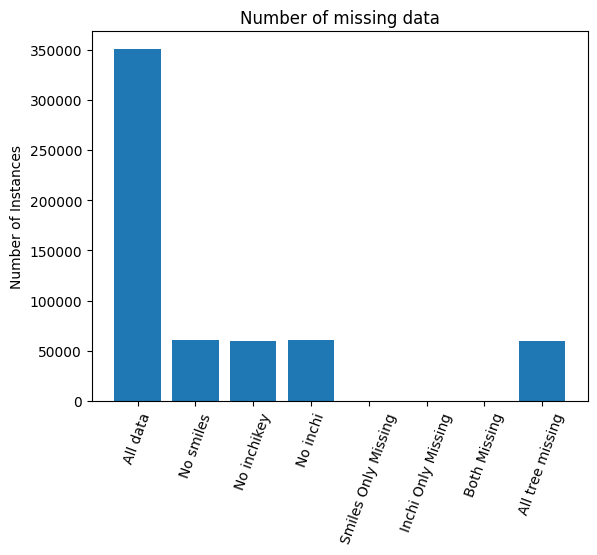

In [25]:
# STATISTICS VISUALIZATION

# x-coordinates of left sides of bars 
parameters_missing = [i for i in range(len(missing_df))]
  
# heights of bars
height = [i for i in missing_df.Count]
  
# labels for bars
tick_label = ['All data', 'No smiles', 'No inchikey', 'No inchi', 'Smiles Only Missing',
              'Inchi Only Missing', 'Both Missing', 'All tree missing']
  

plt.bar(parameters_missing, height, tick_label = tick_label,
        width = 0.8)
  
plt.xlabel('')
plt.xticks(rotation=70)
plt.ylabel('Number of Instances')
plt.title('Number of missing data')
plt.show()

#### Identifier reconstruction

We have approximately 60k data that we are unable to work with. They do not include any identifiers (inchi, inchikey, or SMILES) so we are dropping them. SMILES is crucial for us, so for molecules that don't include a valid SMILES string but include another identifier we will try to reconstruct it. If that fails, we will drop such molecule too.

In [44]:
# Filter and try to restore corupted smiles
# both tools are used, with help of rdkit and matchms as well
# e add the smiles destereo and canonization

def reconstruct_information(dataset):
    updated_dataset = []
    for spectrum in tqdm(dataset):
        smiles = spectrum.get('smiles')
        # all missing
        if smiles == None and spectrum.get('inchikey') == None and spectrum.get('inchi') == None:
            continue
            
        #check weather smiles is syntactically valid or molecule is chemically reasonable
        if (smiles == None or \
            Chem.MolFromSmiles(smiles, sanitize=False) == None or\
            Chem.MolFromSmiles(smiles) == None) and\
            spectrum.get('inchi') != None:
            
            # try to convert from inchi
            tmp = Chem.inchi.MolFromInchi(spectrum.get('inchi'))
            if tmp != None:
                spectrum.set('smiles', Chem.MolToSmiles(tmp))
                smiles = spectrum.get('smiles')
        
        # try with matchms
        if smiles == None and spectrum.get('inchi') != None:
            spectrum = matchms.filtering.derive_smiles_from_inchi(spectrum)
            smiles = spectrum.get('smiles')

        if smiles == None:
            continue
            
        updated_dataset.append(spectrum)
    return updated_dataset

In [45]:
reconstructed_dataset = reconstruct_information(nist_dataset)

  0%|          | 0/350618 [00:00<?, ?it/s][18:38:35] Explicit valence for atom # 0 B, 5, is greater than permitted
[18:38:35] Explicit valence for atom # 0 B, 5, is greater than permitted
[18:38:35] ERROR: Explicit valence for atom # 0 B, 5, is greater than permitted

  1%|          | 3604/350618 [00:00<00:20, 16782.73it/s][18:38:35] Explicit valence for atom # 1 Cl, 7, is greater than permitted
[18:38:35] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[18:38:35] ERROR: Explicit valence for atom # 0 Cl, 7, is greater than permitted

  3%|▎         | 11492/350618 [00:00<00:23, 14297.98it/s][18:38:36] Explicit valence for atom # 0 B, 5, is greater than permitted
[18:38:36] Explicit valence for atom # 0 B, 5, is greater than permitted
[18:38:36] ERROR: Explicit valence for atom # 0 B, 5, is greater than permitted

  7%|▋         | 24598/350618 [00:01<00:26, 12281.12it/s][18:38:37] Explicit valence for atom # 0 B, 6, is greater than permitted
[18:38:37] Explicit valence for

In [56]:
print(f"In the dataset there remains {len(reconstructed_dataset)} / {len(nist_dataset)} molecules and all have now SMILES strings")


In the dataset there remains 290313 / 350618 molecules and all have now SMILES strings


#### Remove stereochemistry and canonicalize smiles

In [91]:
def remove_stereochemistry_and_canonicalize(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print(f"Smiles {smiles} is not valid.")
        return None
    Chem.RemoveStereochemistry(mol)
    new_smiles = Chem.MolToSmiles(mol)
    return new_smiles


def remove_stereochemistry_and_canonicalize_whole_dataset(dataset):
    updated_dataset = []
    counter_smiles_changed = 0
    for i, spectrum in enumerate(dataset):
        smiles = spectrum.get('smiles')
        if smiles is None:
            raise ValueError("Smiles is None, reconstruction and filtering poorly done.")
        new_smiles = remove_stereochemistry_and_canonicalize(smiles)
        if new_smiles is None:
            continue
        spectrum.set('smiles', new_smiles)
        if new_smiles != smiles:
            counter_smiles_changed += 1
        updated_dataset.append(spectrum)
    print(f"Number of smiles canonicalized or destereochemicalized: {counter_smiles_changed}")
    return updated_dataset

In [53]:
canonicalized_dataset = remove_stereochemistry_and_canonicalize_whole_dataset(reconstructed_dataset)

[18:45:14] Explicit valence for atom # 0 B, 5, is greater than permitted
[18:45:15] Explicit valence for atom # 1 Cl, 7, is greater than permitted
[18:45:16] Explicit valence for atom # 0 B, 5, is greater than permitted
[18:45:18] Explicit valence for atom # 0 C, 5, is greater than permitted
[18:45:18] Explicit valence for atom # 0 B, 6, is greater than permitted
[18:45:18] Explicit valence for atom # 0 B, 5, is greater than permitted
[18:45:25] SMILES Parse Error: syntax error while parsing: [CH-]1|2C|3=C|4C|5=C1|[Mn]6789|2|3|4|5[CH-]%10[CH-]6[CH-]7[CH-]8[CH-]9%10
[18:45:25] SMILES Parse Error: Failed parsing SMILES '[CH-]1|2C|3=C|4C|5=C1|[Mn]6789|2|3|4|5[CH-]%10[CH-]6[CH-]7[CH-]8[CH-]9%10' for input: '[CH-]1|2C|3=C|4C|5=C1|[Mn]6789|2|3|4|5[CH-]%10[CH-]6[CH-]7[CH-]8[CH-]9%10'
[18:45:26] SMILES Parse Error: syntax error while parsing: [CH-]1|2C|3=C|4C|5=C1|[Fe]6789|2|3|4|5|[N-]%10[CH-]6[CH-]7[CH-]8[CH-]9%10
[18:45:26] SMILES Parse Error: Failed parsing SMILES '[CH-]1|2C|3=C|4C|5=C1|[Fe

Number of smiles canonicalized or destereochemicalized: 1


In [ ]:
unique_smiles = set([obj.get('smiles') for obj in canonicalized_dataset if obj.get('smiles') != None])

In [55]:
print(f"In the dataset there remains {len(canonicalized_dataset)} / {len(nist_dataset)} molecules and all have now canonical SMILES strings")
print(f"\nFrom the remaining there are {len(unique_smiles)} unique SMILES strings.")

In the dataset there remains 290297 / 350618 molecules and all have now canonical SMILES strings

From the remaining there are 243548 unique SMILES strings.


#### Splitting

In [59]:
TRAIN_RATIO = 0.8
VALID_RATIO = 0.1
TEST_RATIO = 0.1

TRAIN_INDEX = 0
VALID_INDEX = 1
TEST_INDEX = 2

In [61]:
# map each spectrum to its smiles
def unique_mapping(dataset):
    
    smiles_dict = dict()
    counter_none = 0
    
    for spectrum in dataset:
        if "smiles" not in spectrum.metadata or spectrum.get("smiles") == None:
            counter_none += 1
            continue
        if spectrum.get("smiles") not in smiles_dict:
            smiles_dict[spectrum.get("smiles")] = [spectrum]
        else:
            smiles_dict[spectrum.get("smiles")].append(spectrum)

    print(f"Missing smiles identifier in {counter_none} cases")
    return smiles_dict

In [ ]:
# generate shuffled indices for train, valid and test 
def generate_index(dataset, train_ratio, valid_ratio, test_ratio):
    dataset_length = len(dataset)
    
    train_idx = np.full(int(dataset_length * train_ratio), 0, dtype=int)
    valid_idx = np.full(int(dataset_length * valid_ratio), 1, dtype=int)
    test_idx = np.full(int(dataset_length * test_ratio), 2, dtype=int)
    
    concatenate_array = np.concatenate((train_idx, valid_idx, test_idx))
    
    np.random.shuffle(concatenate_array)
    
    return concatenate_array

In [62]:
# build list dateset for training, valid and test
# we iterate over all cases with same value and append them to final list in way
# that all train, valid and test does not overlap with duplicities 
# at the end, lists are shuffled to avoid continuous stream of same data
def generate_train_test_dataset(dataset, indices):
    
    train = []
    valid = []
    test = []
 
    for i, spectrums in zip(indices, dataset):
        if i == TRAIN_INDEX:
            for spectrum in dataset[spectrums]:
                train.append(spectrum)
        elif i == VALID_INDEX:
            for spectrum in dataset[spectrums]:
                valid.append(spectrum)
        elif i == TEST_INDEX:
            for spectrum in dataset[spectrums]:
                test.append(spectrum)
                
    random.shuffle(train)
    random.shuffle(valid)
    random.shuffle(test)
    return (train, valid, test)

In [63]:
# saving list in msp format
def save_dataset(dataset, path, name):            
    # makes all intermediate-level directories needed to contain the leaf directory
    os.makedirs(path, mode=0o777, exist_ok=True)
    save_as_msp(dataset, f"{path}/{name}.msp")     

In [65]:
# Perform splitting
nist_dict = unique_mapping(canonicalized_dataset)
DATASET_LENGTH = len(nist_dict)

indices = generate_index(nist_dict, TRAIN_RATIO, VALID_RATIO, TEST_RATIO)
train, valid, test = generate_train_test_dataset(nist_dict, indices)

Missing smiles identifier in 0 cases


#### Save splits to .msp

In [66]:
# The code is commented on to avoid unintentional rewriting of the created dataset.

save_dir = PROJECT_ROOT + "/data/nist"

save_dataset(train, save_dir, "train")
save_dataset(test, save_dir, "test")
save_dataset(valid, save_dir, "valid")

In [72]:
all_data, no_smiles, no_inchikey, no_inchi, no_smile_only, no_inchikey_only,\
            both_missing_counter, all_identifier_missing = count_all(canonicalized_dataset)

unique_smiles = set([obj.get('smiles') for obj in canonicalized_dataset if obj.get('smiles') != None])

In [73]:
print(f"Number of new unique smiles is {len(set(unique_smiles))}")

Number of new unique smiles is 243305


In [74]:
missing_df["Update count"] = [all_data, no_smiles, no_inchikey, no_inchi, no_smile_only, no_inchikey_only,\
            both_missing_counter, all_identifier_missing]

missing_df["Update average"] = missing_df.apply(lambda row: row["Update count"] / all_data, axis = 1)

missing_df

,Count,average,Update count,Update average
All data,350618,1.000000,290297,1.000000
No smiles,60494,0.172535,0,0.000000
No inchikey,60163,0.171591,1,0.000003
No inchi,60757,0.173285,446,0.001536
Smiles Only Missing,191,0.000545,0,0.000000
Inchi Only Missing,454,0.001295,446,0.001536
Both Missing,334,0.000953,0,0.000000
All tree missing,60160,0.171583,0,0.000000


In [75]:
# no overlap test
len(train), len(valid), len(test), len(set(train) & set(valid)), len(set(train) & set(test)), len(set(valid) & set(test))

(232025, 29053, 29218, 0, 0, 0)

### 1.2) NIST dataleaks elimination
In this subsection we ensure that there are no dataleaks between our NIST split and NEIMS 

### 1.3) NIST to .jsonl
In this part of the notebook we create a `.jsonl` containing only SMILES, m/z values and intensities for each molecule. This file will be used in the training process (the finetuning part).

In [128]:
import sys
sys.path.append("..")
from spectra_process_utils import msp2jsonl
from pathlib import Path

100%|██████████| 29218/29218 [00:09<00:00, 3101.65it/s]


In [ ]:

tokenizer = None
for dataset_type in ["train", "valid", "test"]:
    dataset_path = Path(f"{PROJECT_ROOT}/data/nist")
    msp2jsonl(path_msp=dataset_path / f"{dataset_type}.msp",
                      tokenizer = tokenizer,
                      path_jsonl=dataset_path / f"{dataset_type}.jsonl",
                      keep_spectra=True,
                      do_preprocess=False
                      )

In [ ]:
# path 

## 2) SMILES acquisition from ZINC

In this section we download a subset of ZINC20 library (query *2d-standard-annotated-druglike*) that contains SMILES strings but no m/z nor intensities. Finally we want to end up with about 5M molecules in the Synthetic dataset (empirically a good balance between computational intensity and coverage). We observed that the RASSP filter (section 3) lets through about 1/6 of the molecules, therefore we need to sample 30M SMILES strings from ZINC. The steps to replicate our process are:

#### 2.1) Download the ZINC library

With our specification query *2d-standard-annotated-druglike* you download about 1.8B SMILES strings (73GB??). It is necessary to download all of them and sample them afterwards so we cover the whole chemical space. For the download you can use the `download_script` in `PROJECT_ROOT/data/zinc` that we downloaded [here](https://zinc20.docking.org/tranches/home). The ZINC20 database is being continuously updated - though it's just small bits, it makes the sampling process nondeterministic. If you want exactly the same Synthetic dataset as we used you can download the ours.

#### 2.2) Sample to 40M
We further filter the SMILES randomly to 40M, which creates a base for synthetic generation.



RDM:
count num of smiles in all subdirs: find tranches/ -type f -exec wc -l {} \; | awk '{total += $1} END{print total}'
random slice: scripts/make_a_zinc_split.py
preprocess parts of 43M dataset in loop: for i in {0..28} ; do ./run_prepare_data.sh 43M_${i} ; done
add a first line with a legend: sed -i '1 i\smiles zinc_id' 43M_0.smi
concat to one file (without first lines): for FILE in * ; do cat $FILE >> ../all_clean_43M.smi ; done
do a final slice (30M) prepared for datapreprocess pipeline: scripts/make_smiles_file_slice.py 

In [129]:
!mkdir -p {PROJECT_ROOT}/data/zinc/tranches



## 3) RASSP synthetic spectra generation

## 4) NEIMS synthetic spectra generation

## 5) Dataleaks elimination